In [56]:
import torch.nn as nn
import torch
import tracemalloc

In [57]:
def image_graph_edges(H, W, k=5):
    """
    Generates an edges tensor for a graph where each pixel in an HxW image
    is connected to its kxk nearest neighbors, shifting the window at borders.

    Args:
    - H (int): Image height
    - W (int): Image width
    - k (int): Neighborhood size (kxk)
    - device (str): 'cuda' or 'cpu' for tensor allocation

    Returns:
    - torch.Tensor: Edges tensor of shape (num_edges, 2)
    """

    half_k = k // 2

    # Create grid of pixel indices
    row_indices = torch.arange(H)
    col_indices = torch.arange(W)

    grid_r, grid_c = torch.meshgrid(row_indices, col_indices, indexing='ij')
    pixel_indices = grid_r * W + grid_c  # Convert (row, col) to 1D index

    # Create all possible shifts within the kxk neighborhood
    d_row = torch.arange(-half_k, half_k + 1)
    d_col = torch.arange(-half_k, half_k + 1)

    shift_r, shift_c = torch.meshgrid(d_row, d_col, indexing='ij')
    shift_r = shift_r.flatten()
    shift_c = shift_c.flatten()

    # Compute neighbor locations
    neighbor_r = grid_r.unsqueeze(-1) + shift_r
    neighbor_c = grid_c.unsqueeze(-1) + shift_c

    # Shift window for boundary pixels
    neighbor_r = neighbor_r.clamp(0, H - 1)
    neighbor_c = neighbor_c.clamp(0, W - 1)

    # Convert to 1D indices
    neighbor_indices = neighbor_r * W + neighbor_c

    # Create edges
    edges = torch.stack([
        pixel_indices.unsqueeze(-1).expand(-1, -1, k * k),  # Expand for each neighbor
        neighbor_indices
    ], dim=-1)

    return edges.reshape(-1, 2)

In [58]:
import torch.nn.functional as F

In [59]:
from torch_geometric.utils import softmax

In [60]:
import torch.sparse
import gc

class GraphLearning(nn.Module):
    def __init__(self, feature_dim, edges_p_node, device='cuda'):
        super(GraphLearning, self).__init__()
        self.M = nn.Parameter(torch.eye(feature_dim, feature_dim, device=device) * 1.5)
        self.edges_p_node = edges_p_node
        self.device = device

    def forward(self, x, edges):
        """
        let B = batch_size, N = num_nodes, M = num_edges, K = sample_size, C = num_channels, F = feature_dim
        x: tensor of features for each graph (B, N, F)
        edges: tensor of edge indices for each graph (B, M, 2)
        return: incidence matrix C for each graph (B, N, M)
        """
        batch_size, num_nodes, _ = x.shape
        num_edges = edges.shape[1]

        device = self.device

        source_x = x[torch.arange(batch_size).unsqueeze(1), edges[:, :, 0], :] # source_x (B, M, F)
        target_x = x[torch.arange(batch_size).unsqueeze(1), edges[:, :, 1], :] # target_x (B, M, F)
        d = target_x - source_x # d (B, M, F)
        e = torch.einsum("bik,kl,bil->bi", d, self.M, d) # e (B, M)

        batch_indices = torch.arange(batch_size).unsqueeze(1).repeat(2, num_edges).view(-1)
        # batch_indices (B * 2M, )
        row_indices = torch.cat([edges[:, :, 0], edges[:, :, 1]]).view(-1)
        # row_indices (B * 2M, )
        col_indices = torch.cat([torch.arange(num_edges)] * 2).repeat(batch_size,1).view(-1)
        # col_indices (B * 2M, )
        idxs = torch.stack([batch_indices.to(device), row_indices, col_indices.to(device)], dim=0)
        # idxs (3, B * 2M)

        vals = torch.cat([e, -e]).view(-1) # vals (B * 2M, )
        vals = softmax(vals, row_indices) # vals (B * 2M, )

        C = torch.sparse_coo_tensor(idxs, vals, size=(batch_size, num_nodes, num_edges), device=device, ).coalesce()
        # C = C.to_sparse_csr()
        with torch.no_grad():
            del batch_indices, row_indices, col_indices, idxs, vals, source_x, target_x, d, e
            gc.collect()
            torch.cuda.empty_cache()

        # C = torch.sparse.softmax(C, dim=2)
        C = C.to_sparse_coo()
        # C sparse(B, M, N)
        return C


In [ ]:
import torch.sparse

class SparseBMM(torch.autograd.Function):
    @staticmethod
    def forward(ctx, M1, M2):
        assert len(M1.shape) == 3 and len(M2.shape) == 3
        B = M1.shape[0]
        
        # Perform batch sparse-dense matrix multiplication
        O = torch.stack([torch.sparse.mm(M1[i], M2[i]) for i in range(B)], dim=0)

        # Save tensors for backward
        ctx.save_for_backward(M1, M2)
        return O

    @staticmethod
    def backward(ctx, grad_output):
        M1, M2 = ctx.saved_tensors
        B = M1.shape[0]
        
        # Compute gradients for sparse M1 and dense M2
        grad_M1 = torch.stack([torch.sparse.mm(grad_output[i], M2[i].T) for i in range(B)], dim=0)
        grad_M2 = torch.stack([torch.sparse.mm(M1[i].T, grad_output[i]) for i in range(B)], dim=0)

        return grad_M1, grad_M2

# Wrapper function
def my_bmm(M1, M2):
    return SparseBMM.apply(M1, M2)

class SparseCache:
    eyes_c = {}
    zeros_c = {}
    device = 'cpu'
    @staticmethod
    def set_device(device):
        if(SparseCache.device != device):
            SparseCache.eyes_c = {}
            SparseCache.zeros_C = {}
        SparseCache.device = device

    @staticmethod
    def _sparse_eye(S):
        return torch.sparse.spdiags(torch.ones(S),torch.zeros(1, dtype=int),(S,S)).to(SparseCache.device)

    @staticmethod
    def eye_(S):
        SparseCache.eyes_c[(S,S)] = SparseCache.eyes_c.get((S,S),SparseCache._sparse_eye(S))
        return SparseCache.eyes_c[(S,S)]

    def eye(B,S):
        SparseCache.eyes_c[(B,S,S)] = SparseCache.eyes_c.get((B,S,S),torch.stack([SparseCache.eye_(S) for _ in range(B)], dim=0).detach())
        return SparseCache.eyes_c[(B,S,S)]

    def zeros(S):
        SparseCache.zeros_c[S] = SparseCache.zeros_c.get(S,torch.sparse_coo_tensor(size=S, device=SparseCache.device).detach())
        return SparseCache.zeros_c[S]

def sparse_block_matrix(blocks:list[list[torch.Tensor]],row_dim,col_dim):
    nnz = 0
    row_dims = []
    row_col_dims = []
    for row in blocks:
        col_dims = []
        row_d = row[0].shape[row_dim]
        for block in row:
            assert block.shape[row_dim] == row_d, "All blocks in row must have same row dim"
            col_d = block.shape[col_dim]
            nnz += block._nnz()
            col_dims.append(col_d)
        row_dims.append(row_d)
        row_col_dims.append(col_dims)
        assert sum(col_dims) == sum(row_col_dims[0]), "Must have consistent number of columns"
    num_dims = len(blocks[0][0].shape)
    device = blocks[0][0].device
    idxs = torch.empty((num_dims,nnz))
    vals = torch.empty((nnz,))
    idx_offset = 0
    row_offset = 0
    for row_i, row in enumerate(blocks):
        col_offset = 0
        col_dims = row_col_dims[row_i]
        for col_i, block in enumerate(row):
            block = block.coalesce()
            block_idxs = block.indices().clone().detach()
            block_vals = block.values()
            # check submatrix validity
            # _CHECK = torch.sparse_coo_tensor(block_idxs, block_vals, size=block.shape, check_invariants=True).coalesce()
            row_idx = block_idxs[row_dim] + row_offset
            col_idx = block_idxs[col_dim] + col_offset
            block_idxs[row_dim] = row_idx
            block_idxs[col_dim] = col_idx
            nnz = block._nnz()
            idxs[:,idx_offset:idx_offset+nnz] = block_idxs
            vals[idx_offset:idx_offset+nnz] = block_vals
            del block_idxs, row_idx, col_idx
            idx_offset += nnz

            col_offset += col_dims[col_i]
        row_offset += row_dims[row_i]
    out_size = list(blocks[0][0].shape)
    out_size[row_dim] = sum(row_dims)
    out_size[col_dim] = sum(row_col_dims[0])
    out = torch.sparse_coo_tensor(idxs, vals,size=tuple(out_size),device=device,check_invariants=True).coalesce()
    del idxs, vals, out_size
    return out

class ADMMLayer(nn.Module):
    def __init__(self, cg_steps, edges_p_node, sample_size, device):
        super(ADMMLayer, self).__init__()
        self.gamma = nn.Parameter(torch.rand(1, device=device))
        self.alpha = nn.Parameter(torch.rand(cg_steps, device=device))
        self.beta = nn.Parameter(torch.rand(cg_steps, device=device))
        self.cg_steps = cg_steps
        self.edges_p_node = edges_p_node
        self.sample_size = sample_size

        self.device = device
        SparseCache.set_device(device)



    def forward(self, C, H, y, x, q_tilde, mu):
        """
        let B = batch_size, N = num_nodes, M = num_edges, K = sample_size, C = num_channels
        C: incidence matrix of size (B, N, M)
        H: sampling matrix of size (B, K, N)
        y: signal to interpolate of size (B, K, C)
        x: initial guess of size (B, N, C)
        q_tilde: initial guess of size (B, 2M, C)
        mu: initial guess of size (B, 4M + K, C)
        """
        K = self.sample_size
        B, N, channels = x.shape
        _, _, M = C.shape
        gamma = self.gamma
        device = C.device
        mu_a, mu_b, mu_c, mu_d, mu_e = mu.narrow(1, 0, M), mu.narrow(1, M, M), \
                                       mu.narrow(1, 2*M, K), mu.narrow(1, 2*M + K, M), \
                                       mu.narrow(1, 3*M + K, M)
        # mu_a (B,M,C), mu_b (B,M,C), mu_c (B,K,C), mu_d (B,M,C), mu_e (B,M,C)

        q_tilde_1, q_tilde_2 = q_tilde.narrow(1, 0, M), q_tilde.narrow(1, M, M)
        # q_tilde_1 (B,M,C), q_tilde_2 (B,M,C)

        z_n = -1 / gamma * torch.ones(B,M,channels, device=device) \
              - 1 / (2 * gamma) * (mu_a + mu_b + mu_d + mu_e) \
              + 1 / 2 * (q_tilde_1 + q_tilde_2)
        # z_n (B, M, C)

        H_T = H.permute(0,2,1)

        b_cg = 1 / (2 * gamma) * my_bmm(C, (mu_a - mu_b + mu_d - mu_e)) \
            - 1 / gamma * my_bmm(H_T, mu_c) - 1 / 2 * torch.bmm(C, (q_tilde_1 - q_tilde_2)) \
            + my_bmm(H_T, y)
        # b_cg (B, N, C)

        C_T = C.permute(0,2,1)

        L = my_bmm(H_T, H) + my_bmm(C,C_T)
        # L = SparseCache.eye(B,N)
        # L (B, N, N)

        g = - b_cg + my_bmm(L, x)
        # g (B, N, C)

        v = torch.zeros_like(x)
        # v (B, N, C)

        for t in range(self.cg_steps):
            x, v, g = self.cg_update(L, t, x, v, g)

        q_1 = 1 / 2 * (z_n - my_bmm(C_T, x)) + 1 / (2 * gamma) * \
              (mu_a - mu_d + gamma * q_tilde_1)
        # q_1 (B, M, C)
        q_2 = 1 / 2 * (z_n + my_bmm(C_T, x)) + 1 / (2 * gamma) * \
              (mu_b - mu_e + gamma * q_tilde_2)
        # q_2 (B, M, C)

        q = torch.cat([q_1, q_2], dim=1)
        # q (B, 2M, C)

        q_tilde_1_n = q_1 + 1 / (gamma) * mu_d
        q_tilde_1_n = torch.maximum(q_tilde_1_n, torch.zeros_like(q_tilde_1_n, device=device))
        q_tilde_2_n = q_2 + 1 / (gamma) * mu_e
        q_tilde_2_n = torch.maximum(q_tilde_2_n, torch.zeros_like(q_tilde_2_n, device=device))

        q_tilde_n = torch.cat([q_tilde_1_n, q_tilde_2_n], dim=1)
        # q_tilde_n (B, 2M, C)

        A = self.build_A(B, K, M, C_T, H, device)

        B_mat = self.build_B_mat(B, M, N, A, device)

        zxq = torch.cat([z_n, x, q], dim=1)
        # zxq (B, M+N+2M, C)

        b = self.build_b(B,M,channels,y,device)
        # b (B, 2M + K, C)
        bq_tilde = torch.cat([b, q_tilde_n.to_sparse_coo()], dim=1)
        # bq_tilde (B, 2M + K + 2M, C)

        mu_n = mu + gamma * (my_bmm(B_mat,zxq) - bq_tilde)
        # mu_n (B, 2M+K+2M, C)
        with torch.no_grad():
            del B_mat, zxq, b, bq_tilde
            del q_1, q_2, q_tilde_1_n, q_tilde_2_n
            del A, L, g, v, z_n, b_cg
            del mu_a, mu_b, mu_c, mu_d, mu_e
            del C_T, q_tilde_1, q_tilde_2
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()

        return x, q_tilde_n, mu_n


    def cg_update(self, L, t, x, v, g):
        """
        Conjugate gradient update step.
        L: (N, N)
        t: int
        x: (B, N, C)
        v: (B, N, C)
        g: (B, N, C)
        """
        a = self.alpha[t]
        b = self.beta[t]
        g_n = g - a * my_bmm(L, v)
        # g_n (B, N, C)
        v_n = g_n + b * v
        # v_n (B, N, C)
        x_n = - a * v_n + x
        # x_n (B, N, C)
        return x_n, v_n, g_n

    def build_A(self,B,K,M,C_T,H,device):
        I_S = lambda S: SparseCache.eye(B, S)
        I_M = I_S(M) # (M, M)
        Z_S = lambda *S: SparseCache.zeros(S)

        # A_row_0 = torch.cat([I_M, -C_T, -I_M, Z_S(B,M,M)], dim=2)
        # # (B, M, M+N+M+M)
        # A_row_1 = torch.cat([I_M, C_T, Z_S(B,M,M), -I_M], dim=2)
        # # (B, M, M+N+M+M)
        # A_row_2 = torch.cat([Z_S(B, K, M), H, Z_S(B, K, 2*M)], dim=2)
        # # (B, K, M+N+M+M)
        # A = torch.cat([A_row_0, A_row_1, A_row_2], dim=1).detach()
        # # A (B, M+M+K, M+N+M+M)
        # del A_row_0, A_row_1, A_row_2
        A = sparse_block_matrix([
            [I_M, -C_T.coalesce(), -I_M, Z_S(B,M,M)],
            [I_M, C_T.coalesce(), Z_S(B,M,M), -I_M],
            [Z_S(B, K, M), H.coalesce(), Z_S(B, K, 2*M)]],1,2).detach()
        return A

    def build_B_mat(self,B,M,N,A,device):
        I_S = lambda S: SparseCache.eye(B, S)
        I_M = I_S(M) # (M, M)
        Z_S = lambda *S: SparseCache.zeros(S)
        # B_lower_block = torch.cat([Z_S(B, 2 * M, M + N), I_S(2*M)],dim=2)
        # # (B, 2M, M+N+M+M)
        # B_mat = torch.cat([A, B_lower_block], dim=1).detach()
        # # B (B, 2M+K+2M, M+N+2M)
        # del B_lower_block
        B_mat = sparse_block_matrix([[A.coalesce()],[Z_S(B, 2 * M, M + N), I_S(2*M)]],1,2).detach()
        return B_mat

    def build_b(self,B,M,channels,y,device):
        Z_S = lambda *S: SparseCache.zeros(S)
        b = torch.cat([Z_S(B,M,channels),Z_S(B,M,channels),y.to_sparse_coo()], dim=1)
        # b (B, 2M + K, C)
        return b


In [62]:
class ADMMBlock(nn.Module):
    def __init__(self, num_admm_layers, cg_steps, edges_p_node, sample_size, device='cuda'):
        super(ADMMBlock, self).__init__()

        self.num_admm_layers = num_admm_layers
        self.cg_steps = cg_steps
        self.num_edges = edges_p_node
        self.sample_size = sample_size

        self.admm_layers = nn.ModuleList([ADMMLayer(cg_steps, edges_p_node, sample_size, device) for _ in range(num_admm_layers)])
        self.sample_size = sample_size
        self.device = device

    def forward(self, C, H, y):
        """
        let B = batch_size, N = num_nodes, M = num_edges, K = sample_size, C = num_channels
        C: incidence matrix of size (B, N, M)
        H: sampling matrix of size (B, K, N)
        y: signal to interpolate of size (B, K, C)
        """
        batch_size, num_nodes, num_edges = C.shape
        channels = y.shape[-1]
        device = self.device

        x = torch.sparse_coo_tensor(size=(batch_size, num_nodes, channels), device=device)
        # x (B, N, C)
        q_tilde = torch.zeros(size=(batch_size, 2 * num_edges, channels), device=device)
        # q_tilde (B, 2M, C)
        mu = torch.ones(batch_size, 4 * num_edges + self.sample_size, channels, device=device) * 0.1
        # mu (B, 4M+K, C)
        i = 0
        for admm_layer in self.admm_layers:
            i += 1
            x, q_tilde, mu = admm_layer(C, H, y, x, q_tilde, mu)
        return x


In [63]:
class SkipConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)

        self.shortcut = nn.Identity() if in_channels == out_channels else \
                        nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.shortcut.requires_grad_(False)

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)

class ShallowCNN(nn.Module):
    def __init__(self, in_channels, num_heads, channels_per_head):
        super(ShallowCNN, self).__init__()
        self.out_channels = num_heads * channels_per_head
        self.channels_per_head  = channels_per_head
        self.num_heads = num_heads
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, self.out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            SkipConv(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            SkipConv(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            SkipConv(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        """
        let B = batch_size, N = num_nodes = H * W, M = num_edges, K = sample_size, C = num_channels
        x: tensor of values for each graph (B, H, W, C)
        """
        # x: [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        features = self.conv_layers(x)  # [B, 48, H, W]
        # Split into 4 heads of 12 channels each
        heads = torch.split(features, self.channels_per_head, dim=1)  # Each head: [B, 12, H, W]
        heads = [head.permute(0,2,3,1) for head in heads]
        return heads


In [64]:
import gc

class GraphLearnBlock(nn.Module):
    def __init__(self, in_channels, feature_dim, edges_p_node, num_heads, num_admm_layers, cg_steps, sample_size, device='cuda'):
        super(GraphLearnBlock, self).__init__()

        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.edges_p_node = edges_p_node
        self.num_heads = num_heads
        self.num_admm_layers = num_admm_layers
        self.cg_steps = cg_steps
        self.sample_size = sample_size

        self.shallow_cnn = ShallowCNN(in_channels, num_heads, feature_dim)
        self.graph_learnings = nn.ModuleList([GraphLearning(feature_dim, edges_p_node, device) for _ in range(num_heads)])
        self.admm_block = ADMMBlock(num_admm_layers, cg_steps, edges_p_node, sample_size, device)
        self.device = device

    def forward(self, x, edges, H):
        """
        let B = batch_size, N = num_nodes = H * W, M = num_edges, K = sample_size, C = num_channels
        x: predicted tensor of values for each graph (B, H, W, C)
        edges: tensor of edge indices for each graph (B, M, 2)
        H: sampling matrix of size (B, K, N)
        return: new predicted tensor of values for each graph (B, H, W, C)
        """
        batch_size, Ht, Wi, channels = x.shape
        features = self.shallow_cnn(x) # features (B, H, W, feature_dim)

        x = x.view(batch_size, Ht * Wi, -1)
        predicted_xs = []
        for i in range(self.num_heads):
            feat = features[i].view(batch_size, Ht * Wi, -1)
            C = self.graph_learnings[i](feat, edges)
            # C sparse(B, N, M)
            y = my_bmm(H, x)
            # y (B, K, C)
            predicted_x = self.admm_block(C, H, y)
            # predicted_x (B, N, C)
            predicted_xs.append(predicted_x)
            del predicted_x, y
        x_tensor = torch.stack(predicted_xs, dim=0)
        del predicted_xs
        # average over stacked dimension
        # if x_tensor.is_sparse:
        #     x_tensor = x_tensor.coalesce()
        #     x_tensor = x_tensor.to_dense()
        ret =  torch.mean(x_tensor, dim=0).reshape(batch_size, Ht, Wi, -1) # (B, N, C)
        del x_tensor
        gc.collect()
        torch.cuda.empty_cache()
        return ret


In [65]:
class uGTV(nn.Module):
    def __init__(self, in_channels, feature_dim, edges_p_node, num_heads, num_admm_layers, cg_steps, sample_size, num_learn_blocks, device='cuda'):
        super(uGTV, self).__init__()

        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.edges_p_node = edges_p_node
        self.num_heads = num_heads
        self.num_admm_layers = num_admm_layers
        self.cg_steps = cg_steps
        self.sample_size = sample_size
        self.num_learn_blocks = num_learn_blocks

        self.graph_learn_blocks = nn.ModuleList([GraphLearnBlock(in_channels, feature_dim, edges_p_node, num_heads, num_admm_layers, cg_steps, sample_size, device) for _ in range(num_learn_blocks)])
        self.device = device
        self.first_admm = ADMMBlock(num_admm_layers, cg_steps, edges_p_node, sample_size, device)

    def forward(self, y, edges, H, C, og_size):
        """
        let B = batch_size, N = num_nodes, M = num_edges, K = sample_size, C = num_channels
        y: tensor of values for each graph (B, K, C)
        edges: tensor of edge indices for each graph (B, M, 2)
        H: sampling matrix of size (B, K, N)
        C: incidence matrix of size (B, N, M)
        return: tensor of interpolated features x (B, N, C)
        """
        B, K, channels = y.shape
        x = self.first_admm(C, H, y) # (B, N, C)
        Wi, Ht = og_size
        x = x.reshape(B, Ht, Wi, -1)
        for i in range(self.num_learn_blocks):
            x = self.graph_learn_blocks[i](x, edges, H) # (B, N, C)
        return x


In [66]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [67]:
batch_size = 1
num_batches = 5
data_size = batch_size * num_batches
img_w = 32
img_h = 32
channels = 3
num_samples = 256
neighbor_n = 3

feature_dim = 3
node_neighbors = neighbor_n * neighbor_n

num_heads = 4
num_admm_layers = 5
num_cg_steps = 10
num_gl_blocks = 5

E = image_graph_edges(img_w,img_h,neighbor_n)

X = torch.randn((data_size, img_w, img_h, channels))

H = torch.zeros(img_w, img_h, num_samples)
for i in range(num_samples):
    x = i % 16
    y = i // 16
    H[x,y,i] = 1
H = H.view(img_w*img_h,num_samples).T
batch_H = H.repeat(batch_size,1,1).to_sparse_coo().detach()
H = H.repeat(data_size,1,1).to_sparse_coo().detach()

X_F = X.view(data_size, img_w * img_h, channels)
Y_F = my_bmm(H, X_F)

# E = E.repeat(data_size,1,1).detach()
batch_E = E.repeat(batch_size,1,1).detach()

g = GraphLearning(channels,node_neighbors,'cpu')

X_F = X_F
batch_E = batch_E

batch_C = g(X_F[:batch_size], batch_E)

In [68]:
import gc


gc.collect()  # Force garbage collection
# torch.cuda.empty_cache()
# torch.cuda.reset_max_memory_allocated()
# torch.cuda.reset_max_memory_cached()

0

In [69]:
model = uGTV(channels,num_heads,node_neighbors,num_heads,num_admm_layers,num_cg_steps,num_samples,num_gl_blocks,device)

In [70]:
model = model.to(device)

In [71]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
batch_H = batch_H.to(device).detach().requires_grad_(False)
batch_E = batch_E.to(device).detach().requires_grad_(False)
batch_C = batch_C.to(device).detach().requires_grad_(False)

In [73]:
torch.autograd.set_detect_anomaly(False)

for batch_start_index in range(0, data_size, batch_size):
    batch_end_index = min(batch_start_index + batch_size, data_size)
    batch_X = X[batch_start_index:batch_end_index]
    batch_Y = Y_F[batch_start_index:batch_end_index]
    batch_X = batch_X.to(device).detach().to_sparse_coo()
    batch_Y = batch_Y.to(device).detach().to_sparse_coo()
    reconstructed_X = model(batch_Y,batch_E,batch_H,batch_C,(32,32))
    print("Computed X")
    loss = (reconstructed_X - batch_X).square().mean()
    print("Computed Loss")
    # make_dot(loss, params=dict(model.named_parameters())).render("graph", format="png")
    optimizer.zero_grad()
    print("Computing backward")
    loss.backward()
    print("Computing backward")
    optimizer.step()
    print(f"Batch {batch_start_index // batch_size + 1}/{num_batches}, Loss: {loss.detach().item()}")
    del batch_X, batch_Y
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

RuntimeError: Cannot get indices on an uncoalesced tensor, please call .coalesce() first

In [ ]:
og_x = torch.randn(1,32*32,3).to(device)

In [ ]:
my_y = my_bmm(batch_H, og_x)

In [ ]:
rec_x = model(my_y,batch_E,batch_H,batch_C,(32,32))

In [ ]:
from PIL import Image
np_x = og_x[0].view(32,32,-1).cpu().numpy()

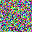

In [ ]:
from torchvision.transforms.functional import to_pil_image
og = to_pil_image(og_x[0].view(32,32,3).permute(2,0,1))
og

In [ ]:
oy = to_pil_image(my_y[0].view(16,16,3).permute(2,0,1))
oy

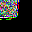

In [ ]:
rec = to_pil_image(rec_x[0].view(32,32,3).permute(2,0,1))
rec

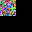

In [ ]:
h_t_y = my_bmm(batch_H.permute(0,2,1), my_y)
hty = to_pil_image(h_t_y[0].view(32,32,3).permute(2,0,1))
hty

In [ ]:
K = prof.key_averages(group_by_input_shape=True)

NameError: name 'prof' is not defined

In [ ]:
print(K.table(sort_by="self_cuda_time_total", row_limit=100))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------